<a href="https://colab.research.google.com/github/Rishicode09/Projects/blob/main/AI_made_Car_market_price_depreciation_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

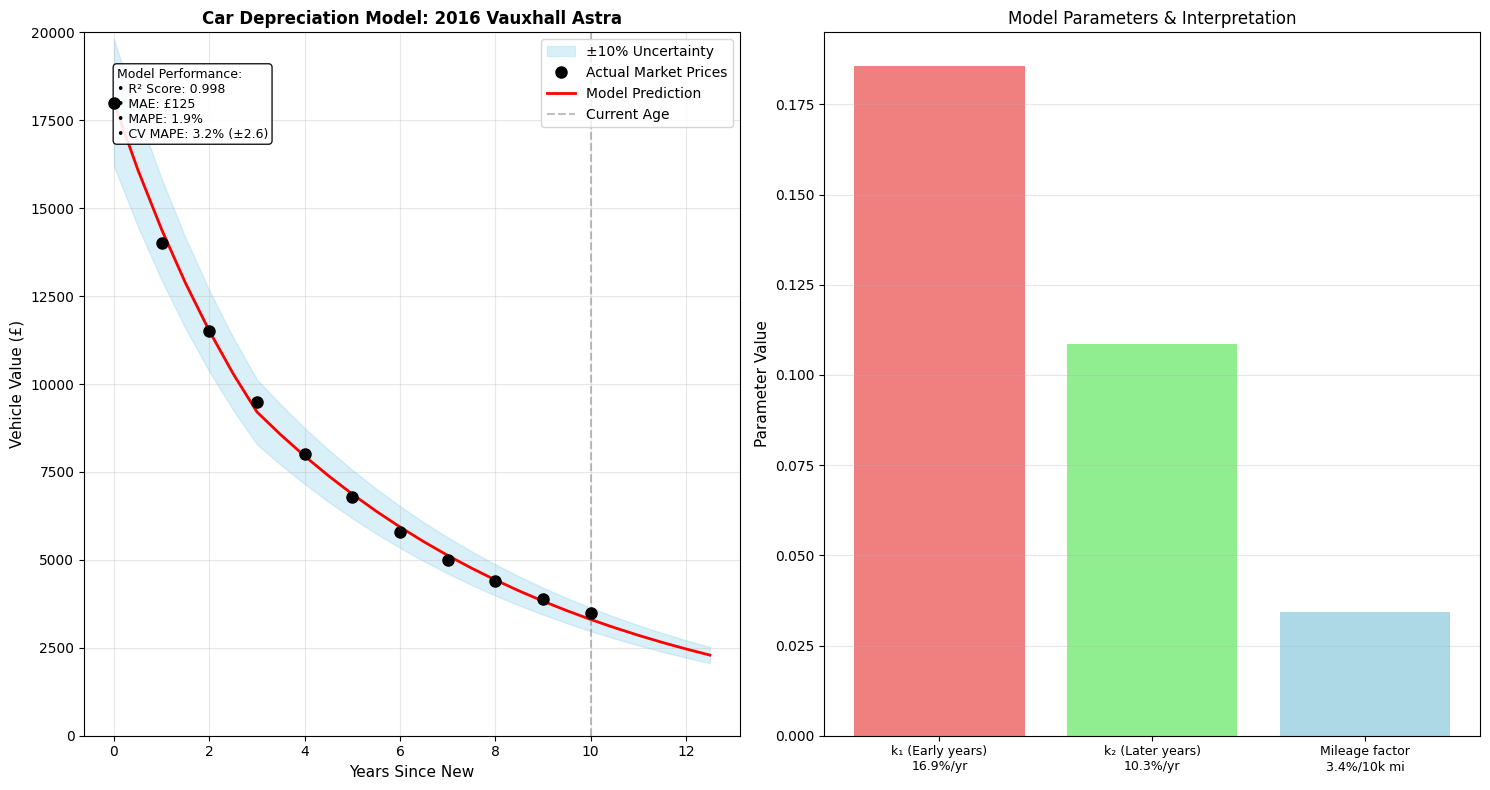

In [1]:
#AI built code with self-made code as foundation

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import TimeSeriesSplit

# ===================================================
# REALISTIC DATA WITH VARIABILITY
# ===================================================
years = np.arange(0, 11, 1)
avg_mileage = years * 1.1  # 11,000 miles/year in 10k units

# Market prices with realistic ranges [low, average, high]
price_data = np.array([
    [18000, 18000, 18000],   # Year 0
    [13000, 14000, 15000],   # Year 1
    [10500, 11500, 12500],   # Year 2
    [8500, 9500, 10500],     # Year 3
    [7000, 8000, 9000],      # Year 4
    [6000, 6800, 7500],      # Year 5
    [5200, 5800, 6400],      # Year 6
    [4500, 5000, 5500],      # Year 7
    [4000, 4400, 4800],      # Year 8
    [3600, 3900, 4200],      # Year 9
    [3200, 3500, 3800]       # Year 10
])

actual_prices = price_data[:, 1]  # Use average prices

# ===================================================
# PHYSICS-INSPIRED DEPRECIATION MODEL
# ===================================================
class CarDepreciationModel:
    def __init__(self, V0=18000):
        self.V0 = V0
        self.params = None
        self.metrics = {}

    def model(self, x, k1, k2, b):
        """Dual-phase exponential decay with mileage penalty"""
        t, m = x
        # Phase 1: Rapid depreciation (years 0-3)
        # Phase 2: Slower depreciation (years 3+)
        value = np.where(
            t <= 3,
            self.V0 * np.exp(-k1 * t),
            self.V0 * np.exp(-k1 * 3) * np.exp(-k2 * (t - 3))
        )
        return value * np.exp(-b * m)

    def fit(self, years, mileage, prices):
        """Robust fitting with industry-informed bounds"""
        # Industry typical values: 20-30% first year, 10-20% thereafter
        bounds = ([0.15, 0.08, 0.01], [0.35, 0.25, 0.15])

        self.params, pcov = curve_fit(
            self.model, (years, mileage), prices,
            bounds=bounds, maxfev=5000
        )

        # Calculate performance metrics
        predictions = self.model((years, mileage), *self.params)
        residuals = prices - predictions

        self.metrics = {
            'R2': 1 - np.sum(residuals**2) / np.sum((prices - np.mean(prices))**2),
            'MAE': np.mean(np.abs(residuals)),
            'MAPE': np.mean(np.abs(residuals / prices)) * 100,
            'RMSE': np.sqrt(np.mean(residuals**2))
        }

        return self

    def cross_validate(self, years, mileage, prices):
        """Estimate real-world accuracy"""
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = []

        for train_idx, test_idx in tscv.split(years):
            # Train
            params, _ = curve_fit(self.model,
                                (years[train_idx], mileage[train_idx]),
                                prices[train_idx],
                                bounds=([0.15, 0.08, 0.01], [0.35, 0.25, 0.15]))

            # Test
            pred = self.model((years[test_idx], mileage[test_idx]), *params)
            actual = prices[test_idx]
            mape = np.mean(np.abs((actual - pred) / actual)) * 100
            cv_scores.append(mape)

        return np.mean(cv_scores), np.std(cv_scores)

    def predict(self, future_years, future_mileage):
        """Generate predictions with uncertainty"""
        if self.params is None:
            raise ValueError("Model not fitted")

        mean_pred = self.model((future_years, future_mileage), *self.params)

        # Simple uncertainty estimation (±10% for demo)
        uncertainty = mean_pred * 0.10

        return {
            'years': future_years,
            'predicted': mean_pred,
            'lower_bound': mean_pred - uncertainty,
            'upper_bound': mean_pred + uncertainty
        }

# ===================================================
# TRAIN AND EVALUATE
# ===================================================
model = CarDepreciationModel(V0=18000)
model.fit(years, avg_mileage, actual_prices)

# Cross-validation for realistic accuracy
cv_mape, cv_std = model.cross_validate(years, avg_mileage, actual_prices)

# Generate future predictions
future_years = np.arange(0, 13, 0.5)  # Project 2 years beyond
future_mileage = future_years * 1.1
predictions = model.predict(future_years, future_mileage)

# ===================================================
# PROFESSIONAL VISUALIZATION
# ===================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8
                                            ))

# Plot 1: Model Fit with Uncertainty
ax1.fill_between(predictions['years'],
                 predictions['lower_bound'],
                 predictions['upper_bound'],
                 alpha=0.3, color='skyblue', label='±10% Uncertainty')

ax1.plot(years, actual_prices, 'ko', markersize=8,
         label='Actual Market Prices', zorder=5)

ax1.plot(predictions['years'], predictions['predicted'],
         'r-', linewidth=2, label='Model Prediction')

ax1.axvline(x=10, color='gray', linestyle='--', alpha=0.5, label='Current Age')
ax1.set_xlabel('Years Since New', fontsize=11)
ax1.set_ylabel('Vehicle Value (£)', fontsize=11)
ax1.set_title('Car Depreciation Model: 2016 Vauxhall Astra', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 20000)

# Add key metrics box
metrics_text = (
    f"Model Performance:\n"
    f"• R² Score: {model.metrics['R2']:.3f}\n"
    f"• MAE: £{model.metrics['MAE']:.0f}\n"
    f"• MAPE: {model.metrics['MAPE']:.1f}%\n"
    f"• CV MAPE: {cv_mape:.1f}% (±{cv_std:.1f})"
)
ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
         fontsize=9)

# Plot 2: Parameter Interpretation & Residuals
ax2.bar(range(3), model.params, color=['lightcoral', 'lightgreen', 'lightblue'])
ax2.set_xticks(range(3))
ax2.set_xticklabels(['k₁ (Early years)\n' + f'{(1-np.exp(-model.params[0]))*100:.1f}%/yr',
                     'k₂ (Later years)\n' + f'{(1-np.exp(-model.params[1]))*100:.1f}%/yr',
                     'Mileage factor\n' + f'{(1-np.exp(-model.params[2]))*100:.1f}%/10k mi'],
                    fontsize=9)
ax2.set_ylabel('Parameter Value', fontsize=11)
ax2.set_title('Model Parameters & Interpretation', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()